---

<h1 style="text-align: center;">ŘEŠENÍ<h1>

### Import & config

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn import metrics
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
%matplotlib inline

# plt style
color_bg_all = "#495464"
color_bg_plot = "#222831"
color_text = "#ffffff"

plt.style.use('ggplot')

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["figure.facecolor"] = color_bg_all
plt.rcParams["grid.color"] = color_bg_all
plt.rcParams["axes.edgecolor"] = color_bg_all
plt.rcParams["axes.facecolor"] = color_bg_plot
plt.rcParams["text.color"] = color_text
plt.rcParams["xtick.color"] = color_text
plt.rcParams["ytick.color"] = color_text
plt.rcParams["axes.labelcolor"] = color_text

In [3]:
df_data = pd.read_csv("data.csv")

### Průzkum dat

In [4]:
print("\x1b[31mDATA\x1b[0m")
display( df_data.head() )

print("\x1b[32mPOPIS\x1b[0m", "\n")
display( df_data.info() )

print("\x1b[33mSTATISTIKY\x1b[0m", "\n")
display( df_data.describe() )

DATA


,ID,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,0,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S,NaN
1,1,1,3,"Dahl, Mr. Karl Edwart",male,45.0,0,0,7598,8.0500,NaN,S,"Australia Fingal, ND"
2,2,0,2,"Watson, Mr. Ennis Hastings",male,NaN,0,0,239856,0.0000,NaN,S,Belfast
3,3,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,NaN
4,4,0,1,"Meyer, Mr. Edgar Joseph",male,28.0,1,0,PC 17604,82.1708,NaN,C,"New York, NY"


POPIS 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   survived   1000 non-null   int64  
 2   pclass     1000 non-null   int64  
 3   name       1000 non-null   object 
 4   sex        1000 non-null   object 
 5   age        797 non-null    float64
 6   sibsp      1000 non-null   int64  
 7   parch      1000 non-null   int64  
 8   ticket     1000 non-null   object 
 9   fare       999 non-null    float64
 10  cabin      222 non-null    object 
 11  embarked   999 non-null    object 
 12  home.dest  573 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 101.7+ KB


None

STATISTIKY 



,ID,survived,pclass,age,sibsp,parch,fare
count,1000.000000,1000.000000,1000.000000,797.000000,1000.000000,1000.000000,999.000000
mean,499.500000,0.391000,2.293000,30.006692,0.499000,0.384000,33.418514
std,288.819436,0.488219,0.840153,14.240416,1.020314,0.873675,53.115334
min,0.000000,0.000000,1.000000,0.166700,0.000000,0.000000,0.000000
25%,249.750000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,499.500000,0.000000,3.000000,28.000000,0.000000,0.000000,14.500000
75%,749.250000,1.000000,3.000000,38.500000,1.000000,0.000000,31.275000
max,999.000000,1.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [5]:
df_data.nunique()

ID           1000
survived        2
pclass          3
name          999
sex             2
age            94
sibsp           7
parch           7
ticket        754
fare          249
cabin         156
embarked        3
home.dest     314
dtype: int64

Další zajímavý vhled do datasetu lze nalézt zde:
https://pandas-profiling.ydata.ai/examples/master/titanic/titanic_report.html

## Předzpracování dat

#### Vyčištění dat

In [6]:
# Sloupec "ID" je redundantní a pro klasifikaci irelevantní, a proto ho z datasetu odstraním.
df_data.drop("ID", axis=1, inplace=True)

# Ze jména si nechám pouze příjmení - tím předpokládám, že zbytek jména nemá při klasifikaci žádný význam
df_data.name = df_data.name.apply(lambda x: x.split(",")[0])

# Ze sloupce "home.dest" si nechám pouze cílovou destinaci - opět předpokládám, že domovská je zbytečná
dest = df_data["home.dest"] \
    .replace(np.nan, "NaN") \
    .apply(lambda x: x.split(",")) \
    .apply(lambda x: x[1] if len(x) == 2 else x[0]) \
    .replace("NaN", np.nan)

df_data.drop("home.dest", axis=1, inplace=True)
df_data["dest"] = dest

# a zobrazím si výsledný dataframe
df_data

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,dest
0,1,3,Andersson,male,27.0,0,0,350043,7.7958,NaN,S,NaN
1,1,3,Dahl,male,45.0,0,0,7598,8.0500,NaN,S,ND
2,0,2,Watson,male,NaN,0,0,239856,0.0000,NaN,S,Belfast
3,1,3,Johnson,female,27.0,0,2,347742,11.1333,NaN,S,NaN
4,0,1,Meyer,male,28.0,1,0,PC 17604,82.1708,NaN,C,NY
...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,1,Cleaver,female,22.0,0,0,113781,151.5500,NaN,S,NaN
996,0,2,Hood,male,21.0,0,0,S.O.C. 14879,73.5000,NaN,S,England
997,1,1,Sagesser,female,24.0,0,0,PC 17477,69.3000,B35,C,NaN
998,0,3,Sage,male,NaN,8,2,CA. 2343,69.5500,NaN,S,NaN


#### Převod příznaků na numerické hodnoty

In [7]:
# nejdříve změním všechny chybějící hodnoty na -1 (analýzou jsem zjistil, že tyto chybějící hodnoty jsou reprezentované pomocí np.nan)
df_data = df_data.replace(np.nan, -1)

# připravím si funkce na transformaci stringových příznaků pomocí categorií a hot one encodingu
# žádné string kategorické příznaky nejsou ordinální, nemusím tedy řešit pořadí hodnot příznaků

def to_cat(data):
    string_cols = data.select_dtypes(['object']).columns
    data[string_cols] = data[string_cols].astype('category').apply(lambda x: x.cat.codes)
    return data

def to_hot(data):
    string_cols = data.select_dtypes(['object']).columns
    for col in string_cols:
        df_tmp = pd.get_dummies(data[col].apply(lambda x: str(x))) # type cast, protože jinak při použití házelo warningy
        data = pd.concat([data, df_tmp], axis=1).reindex(data.index).drop(col, axis=1)
    return data

#### 1.2 Příprava množin

In [8]:
# připravím si funkci na rozdělení dat na trénovací, validační a testovací

def split_data(data):
    rd_seed = 55
    Xdata = data.iloc[:,1:]
    ydata = data.iloc[:,0]

    Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.25, random_state=rd_seed) 
    Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.25, random_state=rd_seed)
    return Xtrain, Xval, Xtest, ytrain, yval, ytest

## Trénování, lazení hyperparametrů a vizualizace

#### kNN

Při trénování budu zkoušet různé kombinace hyperparametrů společně s ponecháním různých příznaků, použitím různého kódování nečíselných hodnot a podobně.

In [9]:
kneighbors = range(3,15)

param_grid = {
    'scaler': [MinMaxScaler(), StandardScaler(), None],
    'k': kneighbors,
    'to_drop': [
        [],
        ["name"], ["ticket"], ["dest"],
        ["name", "ticket"],  ["name", "dest"],  ["ticket", "dest"],
        ["name", "ticket", "dest"]
    ],
    'encoding': [to_cat, to_hot]
}
param_comb = ParameterGrid(param_grid)

val_acc = []
train_acc = []

for params in param_comb:
    data = df_data.copy(deep=True) # make a working copy

    data.drop(params["to_drop"], axis=1, inplace=True)
    data = params["encoding"](data)
    Xtrain, Xval, Xtest, ytrain, yval, ytest = split_data(data)
    
    if params["scaler"] is not None:
        Xtrain = params["scaler"].fit_transform(Xtrain)
        Xval = params["scaler"].transform(Xval)

    clf = KNeighborsClassifier(n_neighbors = params["k"])
    clf.fit(Xtrain, ytrain)

    val_acc.append(clf.score(Xval, yval))
    train_acc.append(clf.score(Xtrain, ytrain))

Zde jsou vidět parametry vedoucí k nejlepšímu score na validační množině. Tyto parametry označím za optimální.

In [10]:
knn_optimal = param_comb[np.argmax(val_acc)]
display(f"Optimal params are: {knn_optimal}")


# model with the optimal parameters
data = df_data.copy(deep=True) # make a working copy
data.drop(knn_optimal["to_drop"], axis=1, inplace=True)
data = knn_optimal["encoding"](data)
Xtrain, Xval, Xtest, ytrain, yval, ytest = split_data(data)
    
if knn_optimal["scaler"] is not None:
    Xtrain = knn_optimal["scaler"].fit_transform(Xtrain)
    Xval = knn_optimal["scaler"].transform(Xval)

best_knn = KNeighborsClassifier(n_neighbors = knn_optimal["k"])
best_knn.fit(Xtrain, ytrain)


display("Scores for the optimum parametres:")
for s,X,y in [("train",Xtrain, ytrain), ("val",Xval, yval), ("test", Xtest, ytest)]:
    print(s.ljust(5," "), ": ", best_knn.score(X, y) )

"Optimal params are: {'to_drop': ['name'], 'scaler': StandardScaler(), 'k': 10, 'encoding': <function to_cat at 0x7fa71cc90700>}"

'Scores for the optimum parametres:'

train :  0.8291814946619217
val   :  0.851063829787234
test  :  0.636
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Nyní ještě vykreslím graf pro různý počet sousedů s použitím zbylých optimálních parametrů.

In [11]:
val_acc = []
train_acc = []

kneighbors = range(3,15)
for k in kneighbors:
    data = df_data.copy(deep=True) # make a working copy

    data.drop(knn_optimal["to_drop"], axis=1, inplace=True)
    data = knn_optimal["encoding"](data)
    Xtrain, Xval, Xtest, ytrain, yval, ytest = split_data(data)
        
    if knn_optimal["scaler"] is not None:
        Xtrain = knn_optimal["scaler"].fit_transform(Xtrain)
        Xval = knn_optimal["scaler"].transform(Xval)

    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(Xtrain, ytrain)

    val_acc.append(clf.score(Xval, yval))
    train_acc.append(clf.score(Xtrain, ytrain))

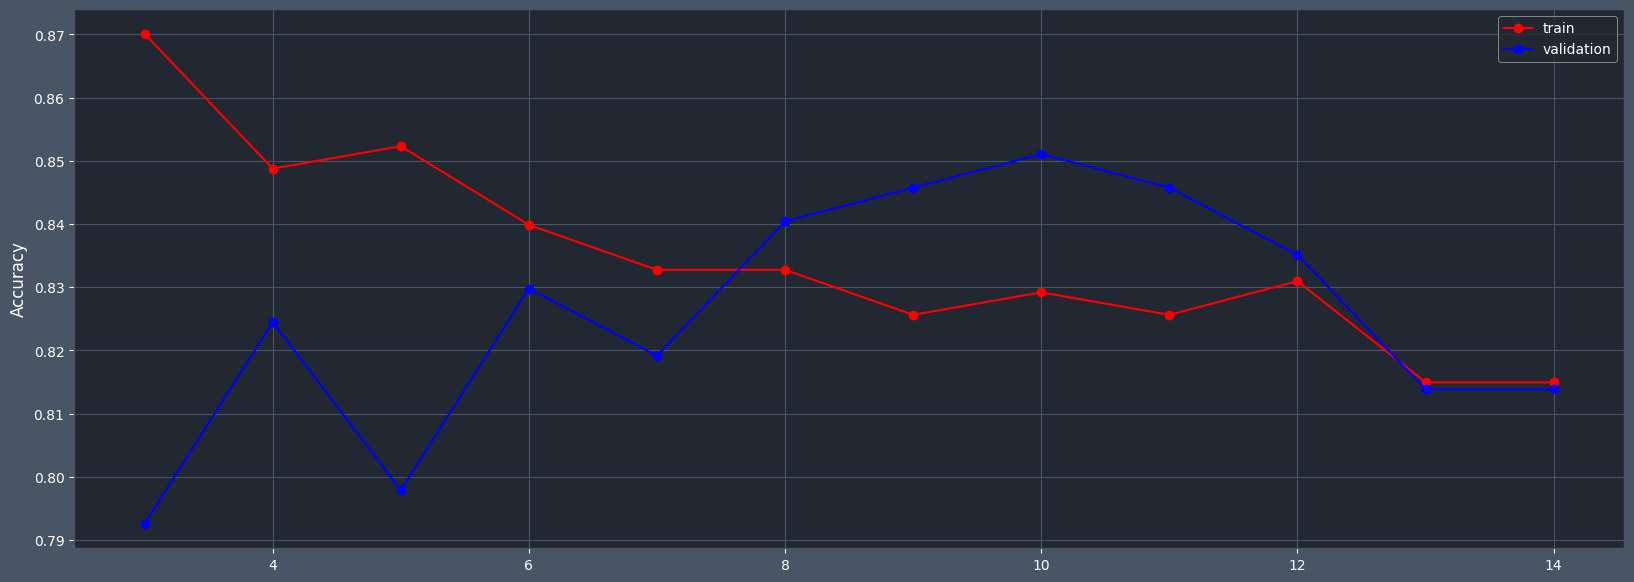

In [12]:
fig = plt.figure(figsize=(20,7))
plt.ylabel('Accuracy')

plt.plot(kneighbors, train_acc,'or-')
plt.plot(kneighbors,val_acc,'ob-')
plt.legend(['train', 'validation'])

#### Rozhodovací strom

Pro rozhodovací strom použiji analogické postupy jako pro kNN.

In [13]:
depth = range(3,15)

param_grid = {
    'scaler': [MinMaxScaler(), StandardScaler(), None],
    'd': depth,
    'to_drop': [
        [],
        ["name"], ["ticket"], ["dest"],
        ["name", "ticket"],  ["name", "dest"],  ["ticket", "dest"],
        ["name", "ticket", "dest"]
    ],
    'encoding': [to_cat, to_hot]
}
param_comb = ParameterGrid(param_grid)

val_acc = []
train_acc = []

for params in param_comb:
    data = df_data.copy(deep=True) # make a working copy

    data.drop(params["to_drop"], axis=1, inplace=True)
    data = params["encoding"](data)
    Xtrain, Xval, Xtest, ytrain, yval, ytest = split_data(data)
    
    if params["scaler"] is not None:
        Xtrain = params["scaler"].fit_transform(Xtrain)
        Xval = params["scaler"].transform(Xval)

    clf = DecisionTreeClassifier(max_depth=params["d"])
    clf.fit(Xtrain, ytrain)

    val_acc.append(clf.score(Xval, yval))
    train_acc.append(clf.score(Xtrain, ytrain))

"Optimal params are: {'to_drop': [], 'scaler': StandardScaler(), 'encoding': <function to_hot at 0x7fa71cc90790>, 'd': 4}"

'Scores for the optimum parametres:'

train :  0.8380782918149466
val   :  0.8351063829787234
test  :  0.584
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


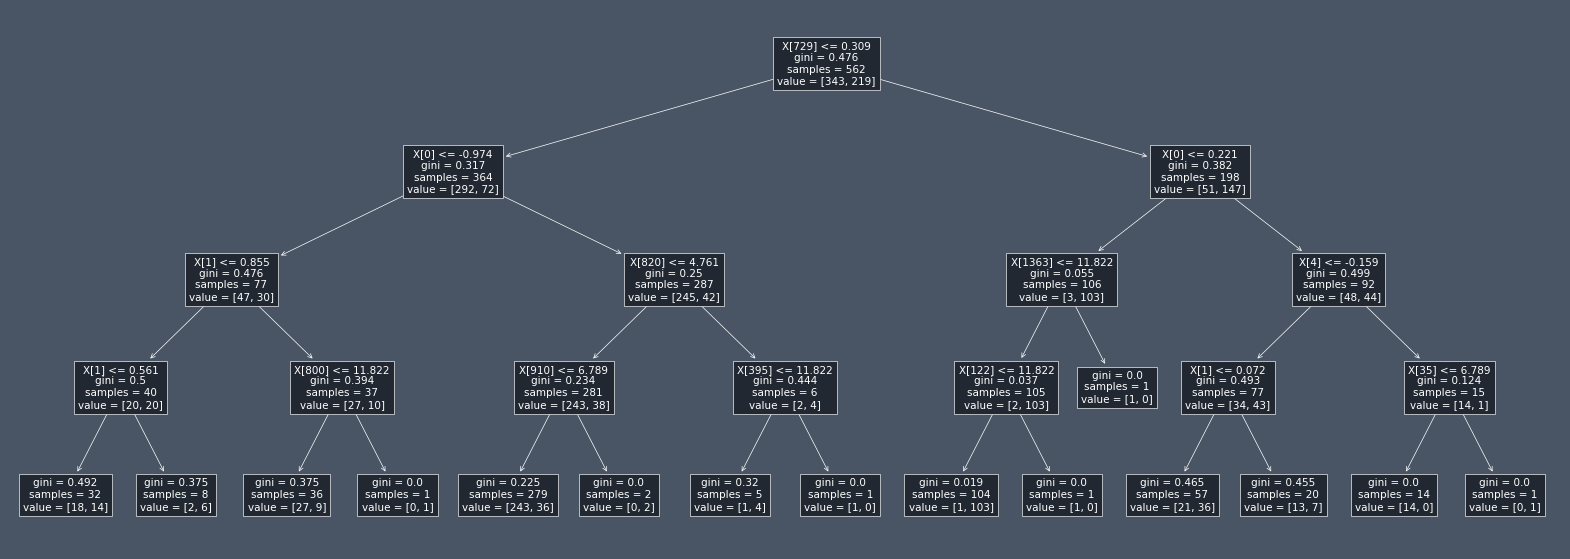

In [14]:
tree_optimal = param_comb[np.argmax(val_acc)]
display(f"Optimal params are: {tree_optimal}")


# model with the optimal parameters
data = df_data.copy(deep=True) # make a working copy
data.drop(tree_optimal["to_drop"], axis=1, inplace=True)
data = tree_optimal["encoding"](data)
Xtrain, Xval, Xtest, ytrain, yval, ytest = split_data(data)
    
if tree_optimal["scaler"] is not None:
    Xtrain = tree_optimal["scaler"].fit_transform(Xtrain)
    Xval = tree_optimal["scaler"].transform(Xval)

best_tree = DecisionTreeClassifier(max_depth=tree_optimal["d"])
best_tree.fit(Xtrain, ytrain)


fig = plt.figure(figsize=(20,7))
tree.plot_tree(best_tree)

display("Scores for the optimum parametres:")
for s,X,y in [("train",Xtrain, ytrain), ("val",Xval, yval), ("test", Xtest, ytest)]:
    print(s.ljust(5," "), ": ", best_tree.score(X, y) )

In [15]:
val_acc = []
train_acc = []

depth = range(1,20)
for d in depth:
    data = df_data.copy(deep=True) # make a working copy

    data.drop(tree_optimal["to_drop"], axis=1, inplace=True)
    data = tree_optimal["encoding"](data)
    Xtrain, Xval, Xtest, ytrain, yval, ytest = split_data(data)
    
    if tree_optimal["scaler"] is not None:
        Xtrain = tree_optimal["scaler"].fit_transform(Xtrain)
        Xval = tree_optimal["scaler"].transform(Xval)

    clf = DecisionTreeClassifier(max_depth= tree_optimal["d"])
    clf.fit(Xtrain, ytrain)

    val_acc.append(clf.score(Xval, yval))
    train_acc.append(clf.score(Xtrain, ytrain))

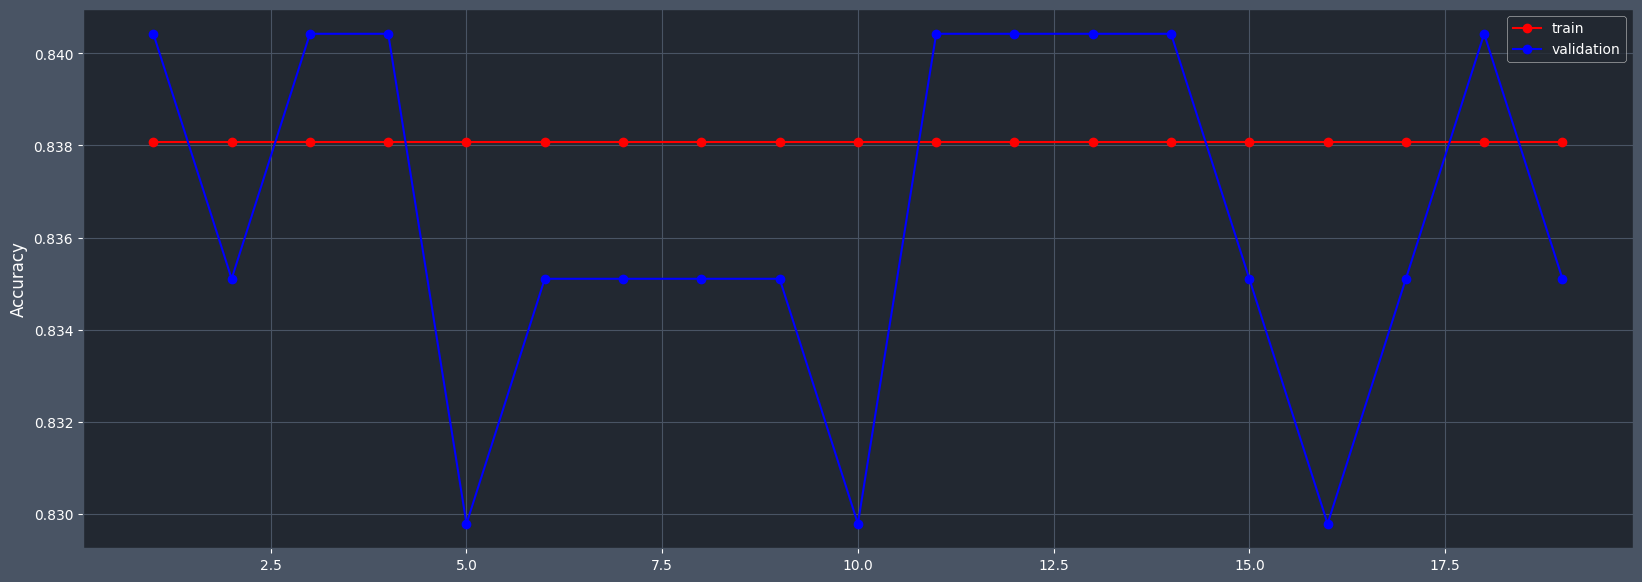

In [16]:
fig = plt.figure(figsize=(20,7))
plt.ylabel('Accuracy')

plt.plot(depth, train_acc,'or-')
plt.plot(depth,val_acc,'ob-')
plt.legend(['train', 'validation'])

## Závěr

Z nafitovaných modelů výše pro obě metody vidíme, že pro různé kombinace příznaků, normalizací a hyperparametrů dosahuje nejlepších výsledků metoda ***k* nejbližších sousedů** s parametry `knn_optimal` popsanými výše.

Nyní tento model s nejoptimálnějšími nalezenými parametry využijeme pro predikci dat ze souboru `evaluation.csv`.

In [17]:
df_eval = pd.read_csv("evaluation.csv")

res = pd.DataFrame()
res["ID"] = df_eval["ID"]

# nejprve data předzpracuji
df_eval.drop("ID", axis=1, inplace=True)
df_eval.replace(np.nan, -1, inplace=True)

df_eval.drop(knn_optimal["to_drop"], axis=1, inplace=True)
df_eval = knn_optimal["encoding"](df_eval)
Xtrain, Xval, Xtest, ytrain, yval, ytest = split_data(df_eval)
    
if knn_optimal["scaler"] is not None:
    Xtrain = knn_optimal["scaler"].fit_transform(Xtrain)
    Xval = knn_optimal["scaler"].transform(Xval)

# a následně predikuji
res["survived"] = best_knn.predict(df_eval)

res.to_csv("results.csv", index=False)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b348c588-60a0-4514-b011-e25b7f8766a1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>